<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/redwinequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [5]:
#%%
# Imports
import io #Used as buffer
import sys
import matplotlib
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, decomposition,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]


In [7]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [8]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf_name):
    i = np.nonzero(np.array(models['name'])==clf_name)[0].squeeze()
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5, iid=False)
    return clf

In [32]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)[:,None]
    elif hasattr(model, "predict_proba"):
      y_pred_soft = model.best_estimator_.predict_proba(X)
    else:
      y_pred_soft = model.best_estimator_.predict(X)[:,None]
    y_pred_th = model.best_estimator_.predict(X) 
    return y_pred_soft, y_pred_th

In [10]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [11]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [12]:
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
wine = pd.read_csv("datasets/winequality-red.csv",sep=';')
Data_X = wine.drop('quality',axis = 1)
Data_y = wine.quality
Data_X = Data_X.to_numpy()
Data_y = Data_y.to_numpy()

In [63]:
# For reproducibility
# tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
#%%
# Assign labels
report_table = []
report_criteria = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'Lasso'
addPredictions = True
applyPCA = True
accuracy = 0
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf_name=clf)
    model.fit(X_train, y_train)

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    # print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test

    if addPredictions:
          # Add predictions
          X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
          X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
          X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)

    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)

    if applyPCA:
          pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
          # Apply PCA transform to all sets
          X_train_GP = pca_GP.transform(X_train_GP)
          X_val_GP = pca_GP.transform(X_val_GP)
          X_test_GP = pca_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP,\
                                   y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th,\
                                   kernel='RBF', norm='labs')
    report_table.append(table)
    
    # # Baseline for comparison
    # crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    # report_criteria.append(crit_table)

    # if accuracy < model.best_estimator_.score(X_val,y_val):
    #     accuracy = model.best_estimator_.score(X_val,y_val)
    #     classifier = model.best_estimator_
    #     X_test_surface_plot = X_test
    #     y_test_surface_plot = y_test
    #     X_train_surface_plot = X_train
    #     y_train_surface_plot = y_train
    #     X_val_surface_plot = X_val
    #     y_val_surface_plot = y_val
    #     scaler_surface_plot = scaleX_GP
    #     exp_surface_plot = exp
    #     table_surface_plot = table

    del(model)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.474  noise: 0.096
Iter 492/500 - Loss: 0.465  noise: 0.096
Iter 493/500 - Loss: 0.468  noise: 0.096
Iter 494/500 - Loss: 0.467  noise: 0.096
Iter 495/500 - Loss: 0.464  noise: 0.096
Iter 496/500 - Loss: 0.465  noise: 0.095
Iter 497/500 - Loss: 0.469  noise: 0.095
Iter 498/500 - Loss: 0.465  noise: 0.095
Iter 499/500 - Loss: 0.473  noise: 0.095
Iter 500/500 - Loss: 0.462  noise: 0.095
evaluating with cuda...


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


evaluating with cuda...
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.470  noise: 0.097
Iter 492/500 - Loss: 0.476  noise: 0.097
Iter 493/500 - Loss: 0.480  noise: 0.097
Iter 494/500 - Loss: 0.479  noise: 0.097
Iter 495/500 - Loss: 0.479  noise: 0.097
Iter 496/500 - Loss: 0.482  noise: 0.097
Iter 497/500 - Loss: 0.487  noise: 0.097
Iter 498/500 - Loss: 0.471  noise: 0.097
Iter 499/500 - Loss: 0.477  noise: 0.096
Iter 500/500 - Loss: 0.482  noise: 0.096
evaluating with cuda...
evaluating with cuda...
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Iter 491/500 - Loss: 0.449  noise: 0.103
Iter 492/500 - Loss: 0.458  noise: 0.103
Iter 493/500 - Loss: 0.457  noise: 0.103
Iter 494/500 - Loss: 0.453  noise: 0.103
Iter 495/500 - Loss: 0.454  noise: 0.103
Iter 496/500 - Loss: 0.454  noise: 0.103
Iter 497/500 - Loss: 0.455  noise: 0.103
Iter 498/500 - Loss: 0.453  noise: 0.103
Iter 499/500 - Loss: 0.458  noise: 0.103
Iter 500/500 - Loss: 0.451  noise: 0.103
evaluating with cuda...
evaluating with cuda...
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Iter 491/500 - Loss: 0.476  noise: 0.115
Iter 492/500 - Loss: 0.477  noise: 0.115
Iter 493/500 - Loss: 0.479  noise: 0.115
Iter 494/500 - Loss: 0.474  noise: 0.115
Iter 495/500 - Loss: 0.471  noise: 0.115
Iter 496/500 - Loss: 0.477  noise: 0.115
Iter 497/500 - Loss: 0.475  noise: 0.115
Iter 498/500 - Loss: 0.472  noise: 0.115
Iter 499/500 - Loss: 0.477  noise: 0.115
Iter 500/500 - Loss: 0.478  noise: 0.115
evaluating with cuda...
evaluating with cuda...
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Iter 491/500 - Loss: 0.470  noise: 0.089
Iter 492/500 - Loss: 0.466  noise: 0.089
Iter 493/500 - Loss: 0.457  noise: 0.089
Iter 494/500 - Loss: 0.468  noise: 0.089
Iter 495/500 - Loss: 0.465  noise: 0.088
Iter 496/500 - Loss: 0.468  noise: 0.088
Iter 497/500 - Loss: 0.458  noise: 0.088
Iter 498/500 - Loss: 0.459  noise: 0.088
Iter 499/500 - Loss: 0.468  noise: 0.088
Iter 500/500 - Loss: 0.464  noise: 0.088
evaluating with cuda...
evaluating with cuda...


In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [64]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
# report_criteria_concat = pd.concat(report_criteria)
# columns_crit = ['rho_user','%reduction_test']
# df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
# df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
# columns_jac = ['rho_user','jaccard']
# df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
# cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
# results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
# df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
# df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table]
df = pd.concat(frames)

In [65]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      # df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [66]:
# Dataframe for results f(x)
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & {} & {} & {} & $\times$ \\
{} & {} & 0.05 & 8.5(7.3-8.9) & 0.05(0.05-0.08) & 8.2(8.1-12.8) & $\surd$ \\
{} & {} & 0.10 & 15.1(14.1-15.7) & 0.12(0.09-0.12) & 16.8(13.1-20.1) & $\surd$ \\
{} & {} & 0.15 & 20.3(20.2-21.4) & 0.17(0.12-0.17) & 23.4(16.4-26.3) & $\surd$ \\
{} & {} & 0.20 & 26.5(26.0-27.2) & 0.23(0.18-0.26) & 32.6(25.2-33.9) & $\surd$ \\



In [ ]:
# Dataframe for comparison f(x)-g(x)
# results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
# fxgx_median = results_fxgx_by_row_index.median()
# fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
# fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# # Baseline comparison statistics (median(q1-q3)) LaTex
# output_fxgx = io.StringIO()
# numRows = fxgx_median.shape[0]
# numCols = fxgx_median.shape[1]
# output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
# output_fxgx.write("------------\n")
# for i in range(numRows):
#   row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
#          else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
#          else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
#   output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
# print(output_fxgx.getvalue())

In [67]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/redwinequality/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx], keys=['fx'], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/redwinequality/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes 

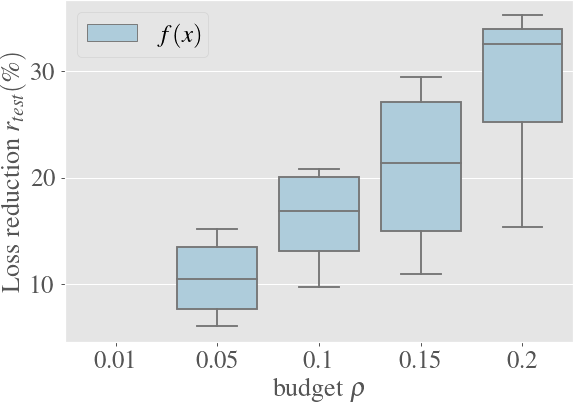

In [68]:
fig, ax = plt.subplots(1,1,figsize=(7, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax, palette=pal)
ax.set_xlabel(r'budget $\rho$')
ax.set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax.legend(loc='upper left')
# pal = sns.color_palette('BuGn_r')
# sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
# ax[1].set_xlabel(r'budget $\rho$')
# ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fx = "drive/My Drive/NIPS2020/results/redwinequality/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx, bbox_inches='tight', facecolor='w')